## Setup

In [1]:
from collections import defaultdict
from glob import glob
import os
from typing import List, Dict
import yaml

from tensorboard.backend.event_processing import event_accumulator
import numpy as np
import plotly.graph_objects as go

BASE_PATH = "old_runs_sb3"

In [2]:
def ci95(std_dev, n_trials: int) -> float:
    return 1.96 * (
        std_dev / np.sqrt(n_trials)
    )  # 95% confidence interval


def get_color(idx, alpha):
    colors = [
        "rgba(99, 110, 250,",
        "rgba(239, 85, 59,",
        "rgba(0, 204, 150,",
        "rgba(171, 99, 250,",
        "rgba(255, 161, 90,",
        "rgba(25, 211, 243,",
        "rgba(255, 102, 146,",
        "rgba(182, 232, 128,",
        "rgba(255, 151, 255,",
        "rgba(254, 203, 82,",
    ]
    return colors[idx % len(colors)] + str(alpha) + ")"

In [3]:
random_results = {
    # w: (mean, 95% confidence interval)
    2: {
        "eval/mean_reward": (-41.38883333333334, ci95(50.217405158581336, 1000)),
        "eval/success_rate": (1.0, ci95(0.0, 1000)),
    },
    3: {
        "eval/mean_reward": (-615.9455625, ci95(54.096148844087956, 1000)),
        "eval/success_rate": (0.006, ci95(0.0772269383052313, 1000)),
    },
    4: {
        "eval/mean_reward": (-521.9251777777773, ci95(26.923752997348288, 1000)),
        "eval/success_rate": (0.0, ci95(0.0, 1000)),
    },
    5: {
        "eval/mean_reward": (-428.0011354166666, ci95(23.243022947447443, 1000)),
        "eval/success_rate": (0.0, ci95(0.0, 1000)),
    },
}

In [30]:
def extract_scalar_values(logdir, metric_name):
    tensorboard_files = glob(os.path.join(logdir, "**", "events.*"))
    assert len(tensorboard_files) == 1, f"{len(tensorboard_files)} != 1 tensorboard files found in {logdir}"
    event_acc = event_accumulator.EventAccumulator(tensorboard_files[0])
    event_acc.Reload()
    return [event.value for event in event_acc.Scalars(metric_name)]


def plot_curves(curves, title=None, metric_name="Return", ws_filter=None, sparse=False):
    learning_curve = go.Figure()

    # add horizontal lines from random_results
    for w, metrics in random_results.items():
        if (ws_filter is not None and w not in ws_filter) or ("reward" in metric_name and sparse):
            continue
        mean, ci = metrics[metric_name]
        learning_curve.add_hline(
            y=mean,
            line_dash="dot",
            line_color="black",
            annotation_text=f"Random {w}x{w}",
            annotation_position="bottom right",
        )
        learning_curve.add_hrect(
            y0=mean - ci,
            y1=mean + ci,
            fillcolor="black",
            opacity=0.1,
            line_width=0,
        )
    

    for idx, (run_name, x_values, y_values, lower_bound, upper_bound) in enumerate(
        curves
    ):
        learning_curve.add_trace(
            go.Scatter(
                x=x_values,
                y=y_values,
                mode="lines",
                name=f"{run_name.split('/')[-1]}",
                line=dict(color=get_color(idx, 1)),
            )
        )
        learning_curve.add_trace(
            go.Scatter(
                x=x_values,
                y=lower_bound,
                fill=None,
                mode="lines",
                showlegend=False,
                line=dict(color=get_color(idx, 0.01)),
            )
        )
        learning_curve.add_trace(
            go.Scatter(
                x=x_values,
                y=upper_bound,
                fill="tonexty",
                mode="lines",
                showlegend=False,
                line=dict(color=get_color(idx, 0.01)),
            )
        )

    learning_curve.update_layout(
        title=title,
        xaxis_title="Step",
        yaxis_title=metric_name,
        template="plotly",
        width=800,
        height=500,
        legend=dict(
            yanchor="bottom",
            y=0.01,
            xanchor="right",
            x=0.9905,
        )
    )

    learning_curve.show()

## Select experiments

An *experiment* compares different *trials*, which have many *runs* (for each seed).

In [28]:
def get_trial_curves(trial_run_dirs, metric_name):
    values_list = [
        extract_scalar_values(run_dir, metric_name) for run_dir in trial_run_dirs
    ]
    max_length = max(len(values) for values in values_list)

    mean_values = np.array([])
    std_dev_values = np.array([])

    while len(mean_values) < max_length:
        processed = len(mean_values)
        section_length = min(
            len(values[processed:]) for values in values_list if len(values) > processed
        )
        section_means = np.mean(
            [
                values[processed : processed + section_length]
                for values in values_list
                if len(values) > processed
            ],
            axis=0,
        )
        section_std_devs = np.std(
            [
                values[processed : processed + section_length]
                for values in values_list
                if len(values) > processed
            ],
            axis=0,
        )
        mean_values = np.concatenate((mean_values, section_means))
        std_dev_values = np.concatenate((std_dev_values, section_std_devs))

    conf_int = ci95(std_dev_values, len(trial_run_dirs))

    x_values = list(range(1, len(mean_values) + 1))
    y_values = mean_values
    lower_bound = mean_values - conf_int
    upper_bound = mean_values + conf_int

    return x_values, y_values, lower_bound, upper_bound


def get_trials_and_runs(
    experiment_name,
    config_queries: List[dict],
    key_to_compare: str,
    metric_name: str,
    debug=False,
):
    if type(config_queries) is not list:
        config_queries = [config_queries]

    trials = defaultdict(list)
    for config_file in glob(os.path.join(BASE_PATH, "*/configs.yaml")):
        with open(config_file, "r") as f:
            config = yaml.load(f, Loader=yaml.FullLoader)

        for config_query in config_queries:
            # perform an "or" operation between queries in the list
            for query_key, query_value in config_query.items():
                if config.get(query_key) != query_value:
                    break
            else:
                # add run to respective trial
                trials[config[key_to_compare]].append(
                    os.path.join(BASE_PATH, config["run_id"])
                )
                if debug:
                    print(config[key_to_compare], config["run_id"], config)

    curves = []
    for trial_name, run_dirs in sorted(trials.items()):
        print(f"Processing {trial_name}", run_dirs)
        curves.append(
            (
                f"{trial_name} ({len(run_dirs)} seeds)",
                *get_trial_curves(run_dirs, metric_name),
            )
        )

    ws_filter = [config_query.get("env_h") or config_query.get("env_w") for config_query in config_queries]
    ws_filter = list(set(ws_filter))
    ws_filter = [w for w in ws_filter if w is not None]
    return plot_curves(
        curves,
        title=f"{experiment_name} {metric_name.split('/')[-1]}",
        metric_name=metric_name,
        ws_filter=ws_filter if len(ws_filter) > 0 else None,
        sparse=any([config_query.get("env_sparse_rewards") for config_query in config_queries])
    )


def get_reward_and_success(*args, **kwargs):
    get_trials_and_runs(*args, **{**kwargs, "metric_name": "eval/mean_reward"})
    get_trials_and_runs(*args, **{**kwargs, "metric_name": "eval/success_rate"})

## 2x2

In [33]:
get_reward_and_success(
    "2x2",
    [
        {
            "env_sparse_rewards": False,
            "env_sparse_mode": None,
            "env_shuffle_steps": 8,
            "env_win_reward": 10,
            "env_h": 2,
        },
        {
            "env_sparse_rewards": False,
            "env_sparse_mode": None,
            "env_shuffle_steps": 8,
            "env_win_reward": None,
            "env_h": 2,
        },
        {
            "env_sparse_rewards": False,
            "env_sparse_mode": "invalid_and_win",
            "env_shuffle_steps": 8,
            "env_win_reward": None,
            "env_h": 2,
        },
    ],
    "env_variation",
)

In [28]:
get_reward_and_success(
    "2x2",
    [
        {
            "env_sparse_rewards": False,
            "env_shuffle_steps": 8,
            "env_win_reward": 10,
            "env_h": 2,
            "env_variation": "image",
        },
        {
            "env_sparse_rewards": False,
            "env_shuffle_steps": 8,
            "env_win_reward": None,
            "env_h": 2,
            "env_variation": "image",
        },
    ],
    "env_image_folder",
)

Processing ./imgs/imagenet-1k ['old_runs_sb3/20240129_173328-image_imagenet-1k_2x2_304', 'old_runs_sb3/20240129_184943-image_imagenet-1k_2x2_420', 'old_runs_sb3/20240129_203817-image_imagenet-1k_2x2_650']
Processing ./imgs/mnist ['old_runs_sb3/20240129_173304-image_mnist_2x2_304', 'old_runs_sb3/20240129_194225-image_mnist_2x2_420', 'old_runs_sb3/20240129_215209-image_mnist_2x2_650']
Processing ./imgs/single ['old_runs_sb3/20240129_173319-image_single_2x2_304', 'old_runs_sb3/20240129_190858-image_single_2x2_650', 'old_runs_sb3/20240129_182355-image_single_2x2_420']
[2]


Processing ./imgs/imagenet-1k ['old_runs_sb3/20240129_173328-image_imagenet-1k_2x2_304', 'old_runs_sb3/20240129_184943-image_imagenet-1k_2x2_420', 'old_runs_sb3/20240129_203817-image_imagenet-1k_2x2_650']
Processing ./imgs/mnist ['old_runs_sb3/20240129_173304-image_mnist_2x2_304', 'old_runs_sb3/20240129_194225-image_mnist_2x2_420', 'old_runs_sb3/20240129_215209-image_mnist_2x2_650']
Processing ./imgs/single ['old_runs_sb3/20240129_173319-image_single_2x2_304', 'old_runs_sb3/20240129_190858-image_single_2x2_650', 'old_runs_sb3/20240129_182355-image_single_2x2_420']
[2]


## Raw Sparse vs Dense

In [41]:
get_reward_and_success(
    "Sparse",
    [
        {
            # "env_sparse_rewards": False,
            "env_variation": "onehot",
            # "env_h": 5
            },
    ],
    "env_h",
)

Processing 2 ['old_runs_sb3/20240127_171639-onehot_2x2_304', 'old_runs_sb3/20240127_171827-onehot_2x2_sparse_win_304', 'old_runs_sb3/20240127_174427-onehot_2x2_420', 'old_runs_sb3/20240127_174706-onehot_2x2_sparse_win_420', 'old_runs_sb3/20240127_181442-onehot_2x2_650', 'old_runs_sb3/20240127_181646-onehot_2x2_sparse_win_650', 'old_runs_sb3/20240207_185501-onehot_2x2_304', 'old_runs_sb3/20240207_190447-onehot_2x2_420', 'old_runs_sb3/20240207_191306-onehot_2x2_650']
Processing 3 ['old_runs_sb3/20240127_184243-onehot_3x3_sparse_win_304', 'old_runs_sb3/20240127_190554-onehot_3x3_sparse_win_420', 'old_runs_sb3/20240127_190719-onehot_3x3_420', 'old_runs_sb3/20240127_192957-onehot_3x3_sparse_win_650', 'old_runs_sb3/20240127_193338-onehot_3x3_650', 'old_runs_sb3/20240127_184132-onehot_3x3_304', 'old_runs_sb3/20240207_192228-onehot_3x3_304', 'old_runs_sb3/20240207_193329-onehot_3x3_420', 'old_runs_sb3/20240207_194617-onehot_3x3_650']
Processing 4 ['old_runs_sb3/20240127_195355-onehot_4x4_spars

Processing 2 ['old_runs_sb3/20240127_171639-onehot_2x2_304', 'old_runs_sb3/20240127_171827-onehot_2x2_sparse_win_304', 'old_runs_sb3/20240127_174427-onehot_2x2_420', 'old_runs_sb3/20240127_174706-onehot_2x2_sparse_win_420', 'old_runs_sb3/20240127_181442-onehot_2x2_650', 'old_runs_sb3/20240127_181646-onehot_2x2_sparse_win_650', 'old_runs_sb3/20240207_185501-onehot_2x2_304', 'old_runs_sb3/20240207_190447-onehot_2x2_420', 'old_runs_sb3/20240207_191306-onehot_2x2_650']
Processing 3 ['old_runs_sb3/20240127_184243-onehot_3x3_sparse_win_304', 'old_runs_sb3/20240127_190554-onehot_3x3_sparse_win_420', 'old_runs_sb3/20240127_190719-onehot_3x3_420', 'old_runs_sb3/20240127_192957-onehot_3x3_sparse_win_650', 'old_runs_sb3/20240127_193338-onehot_3x3_650', 'old_runs_sb3/20240127_184132-onehot_3x3_304', 'old_runs_sb3/20240207_192228-onehot_3x3_304', 'old_runs_sb3/20240207_193329-onehot_3x3_420', 'old_runs_sb3/20240207_194617-onehot_3x3_650']
Processing 4 ['old_runs_sb3/20240127_195355-onehot_4x4_spars

In [30]:
get_reward_and_success(
    "Sparse",
    [
        {
            "env_sparse_rewards": True,
            "env_variation": "onehot",
            # "env_h": 5
        },
    ],
    "env_h",
)

Processing 2 ['old_runs_sb3/20240127_171827-onehot_2x2_sparse_win_304', 'old_runs_sb3/20240127_174706-onehot_2x2_sparse_win_420', 'old_runs_sb3/20240127_181646-onehot_2x2_sparse_win_650']
Processing 3 ['old_runs_sb3/20240127_184243-onehot_3x3_sparse_win_304', 'old_runs_sb3/20240127_190554-onehot_3x3_sparse_win_420', 'old_runs_sb3/20240127_192957-onehot_3x3_sparse_win_650']
Processing 4 ['old_runs_sb3/20240127_195355-onehot_4x4_sparse_win_304', 'old_runs_sb3/20240127_201832-onehot_4x4_sparse_win_420', 'old_runs_sb3/20240127_204452-onehot_4x4_sparse_win_650']
Processing 5 ['old_runs_sb3/20240127_211011-onehot_5x5_sparse_win_304', 'old_runs_sb3/20240127_213518-onehot_5x5_sparse_win_420', 'old_runs_sb3/20240127_220011-onehot_5x5_sparse_win_650']
[]


Processing 2 ['old_runs_sb3/20240127_171827-onehot_2x2_sparse_win_304', 'old_runs_sb3/20240127_174706-onehot_2x2_sparse_win_420', 'old_runs_sb3/20240127_181646-onehot_2x2_sparse_win_650']
Processing 3 ['old_runs_sb3/20240127_184243-onehot_3x3_sparse_win_304', 'old_runs_sb3/20240127_190554-onehot_3x3_sparse_win_420', 'old_runs_sb3/20240127_192957-onehot_3x3_sparse_win_650']
Processing 4 ['old_runs_sb3/20240127_195355-onehot_4x4_sparse_win_304', 'old_runs_sb3/20240127_201832-onehot_4x4_sparse_win_420', 'old_runs_sb3/20240127_204452-onehot_4x4_sparse_win_650']
Processing 5 ['old_runs_sb3/20240127_211011-onehot_5x5_sparse_win_304', 'old_runs_sb3/20240127_213518-onehot_5x5_sparse_win_420', 'old_runs_sb3/20240127_220011-onehot_5x5_sparse_win_650']
[]


In [5]:
get_reward_and_success(
    "Raw Sparse",
    [
        {
            "env_variation": "raw",
            "env_h": 2,
        },
    ],
    "env_sparse_rewards",
)

2024-01-27 16:31:12.176190: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-27 16:31:13.117932: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [45]:
get_reward_and_success(
    "Raw Sparse",
    [
        {
            "env_variation": "raw",
            "env_h": 3,
        },
    ],
    "env_sparse_rewards"
)

## Raw vs Onehot

In [6]:
get_reward_and_success(
    "Raw vs Onehot",
    [
        {
            "env_variation": "raw",
            "env_sparse_rewards": False,
            "env_h": 2,
        },
        {
            "env_variation": "normalized",
            "env_sparse_rewards": False,
            "env_h": 2,
        },
        {
            "env_variation": "onehot",
            "env_sparse_rewards": False,
            "env_h": 2,
        },
    ],
    "env_variation",
)

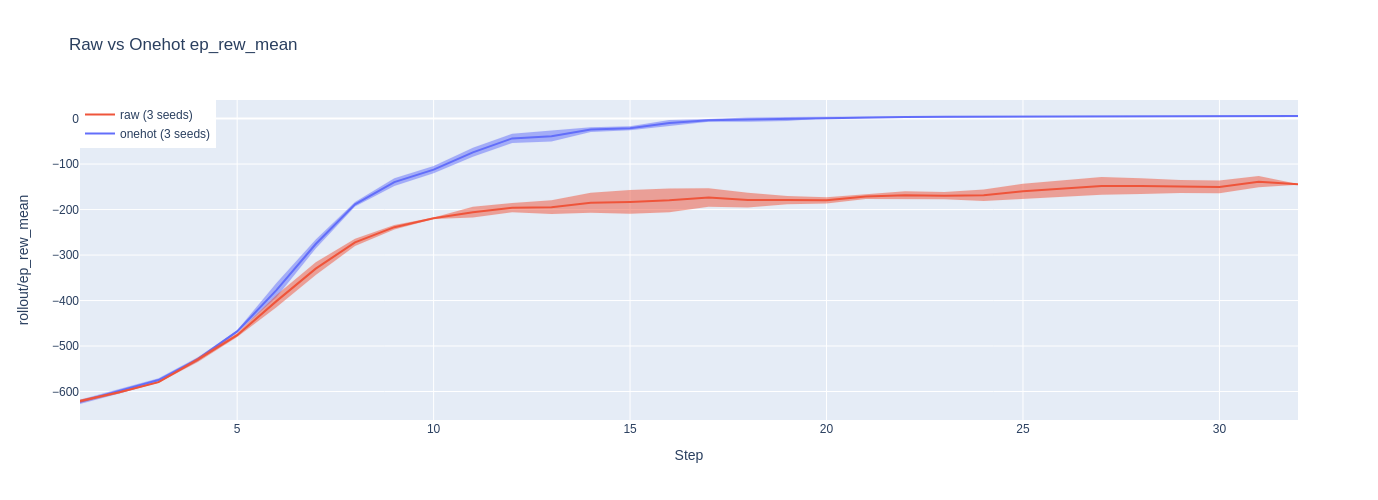

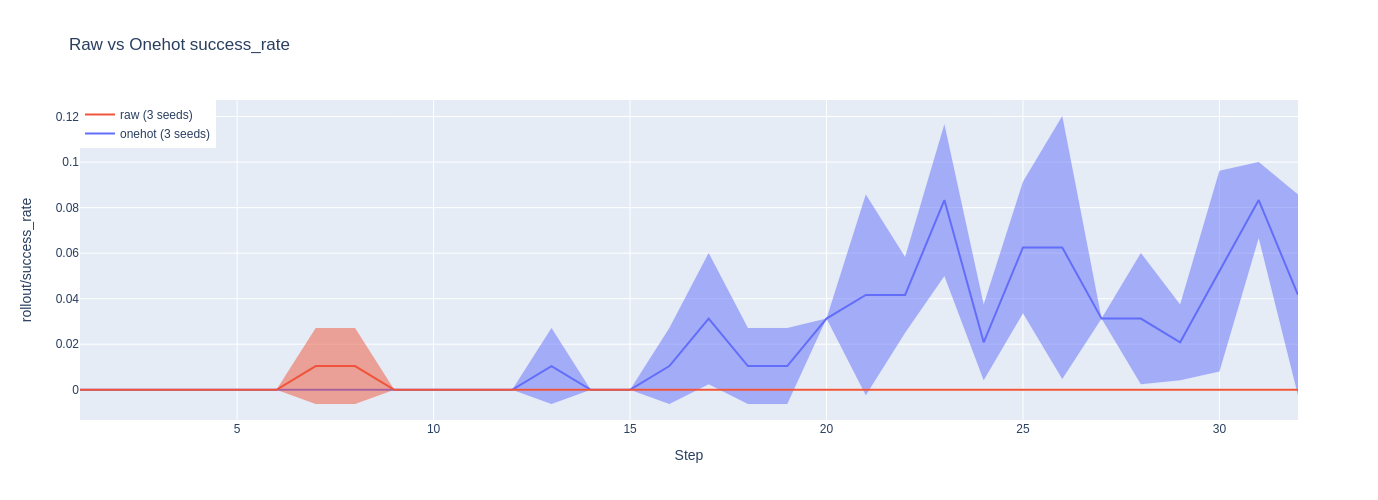

In [28]:
get_trials_and_runs(
    "Raw vs Onehot",
    [
        {
            "env_variation": "raw",
            "env_sparse_rewards": False,
            "env_h": 3,
        },
        {
            "env_variation": "onehot",
            "env_sparse_rewards": False,
            "env_h": 3,
        },
    ],
    "env_variation",
    "rollout/ep_rew_mean"
),
get_trials_and_runs(
    "Raw vs Onehot",
    [
        {
            "env_variation": "raw",
            "env_sparse_rewards": False,
            "env_h": 3,
        },
        {
            "env_variation": "onehot",
            "env_sparse_rewards": False,
            "env_h": 3,
        },
    ],
    "env_variation",
    "rollout/success_rate"
)

## Raw

In [7]:
get_reward_and_success(
    "Raw",
    {
        "env_variation": "raw",
        "env_sparse_rewards": False,
    },
    "env_h",
)

Processing 2 ['runs/20240214_124852-raw_2x2_42']


2024-02-19 16:40:30.988796: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-19 16:40:31.752322: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


KeyError: 'Key eval/mean_reward was not found in Reservoir'

## Normalized

In [8]:
get_reward_and_success(
    "Normalized",
    {
        "env_variation": "normalized",
        "env_sparse_rewards": False,
    },
    "env_h",
)

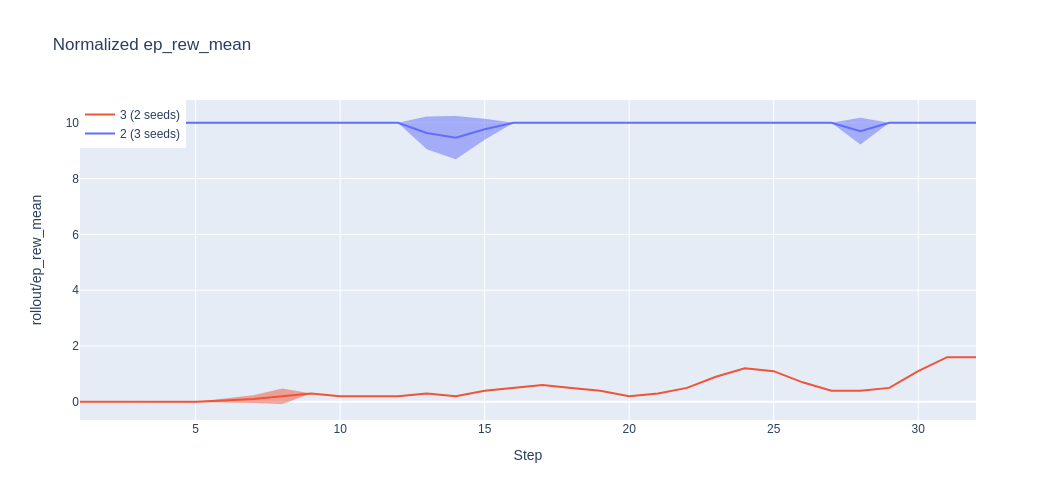

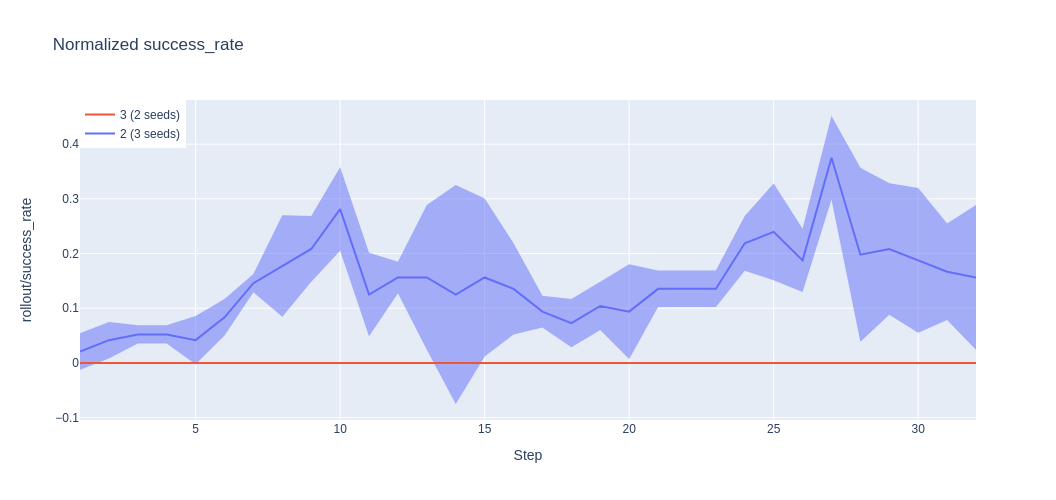

In [6]:
get_trials_and_runs(
    "Normalized",
    {
        "env_variation": "normalized",
        "env_sparse_rewards": True,
        "env_sparse_mode": "win",
    },
    "env_h",
    "rollout/ep_rew_mean"
),
get_trials_and_runs(
    "Normalized",
    {
        "env_variation": "normalized",
        "env_sparse_rewards": True,
        "env_sparse_mode": "win",
    },
    "env_h",
    "rollout/success_rate"
)

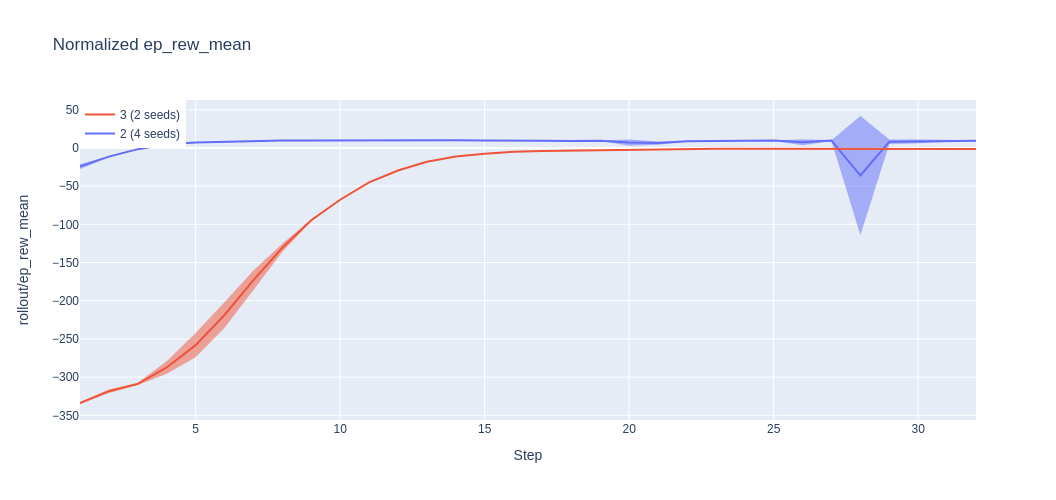

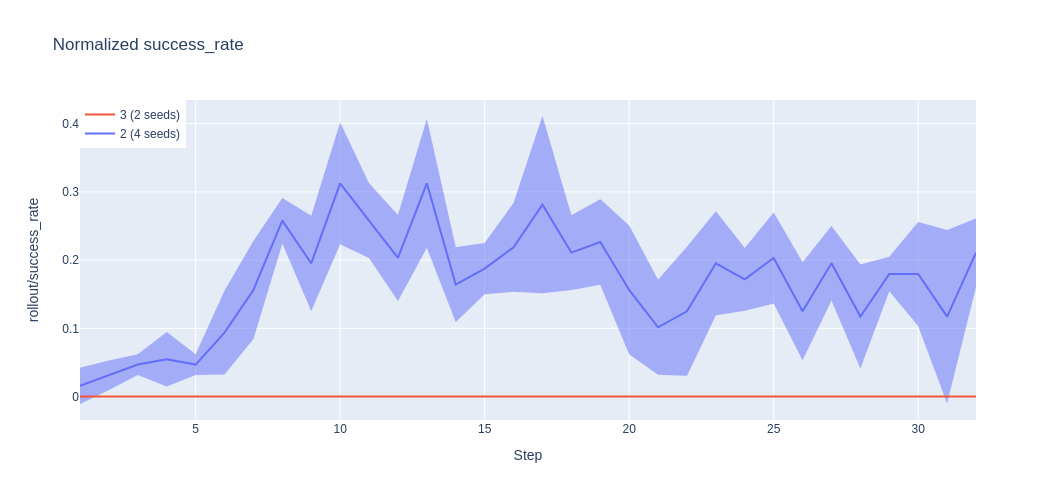

In [7]:
get_trials_and_runs(
    "Normalized",
    {
        "env_variation": "normalized",
        "env_sparse_rewards": True,
        "env_sparse_mode": "invalid_and_win",
    },
    "env_h",
    "rollout/ep_rew_mean"
),
get_trials_and_runs(
    "Normalized",
    {
        "env_variation": "normalized",
        "env_sparse_rewards": True,
        "env_sparse_mode": "invalid_and_win",
    },
    "env_h",
    "rollout/success_rate"
)

## Onehot

In [1]:
get_reward_and_success(
    "Onehot",
    {
        "env_variation": "onehot",
        "env_sparse_rewards": False,
    },
    "env_h",
)

NameError: name 'get_reward_and_success' is not defined

In [7]:
get_reward_and_success(
    "Onehot",
    {
        "env_variation": "onehot",
        "env_sparse_rewards": False,
    },
    "env_h",
)

## Single Image

In [4]:
get_reward_and_success(
    "Single Image",
    {
        "policy": "CnnPolicy", 
        "env_variation": "image",
        "env_image_folder": "./imgs/single"
    },
    "env_h",
),

2024-01-29 23:32:30.805572: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-29 23:32:31.870294: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(None,)

## Mnist

In [7]:
get_reward_and_success(
    "Mnist",
    {
        "policy": "CnnPolicy", 
        "env_variation": "image",
        "env_image_folder": "./imgs/mnist"
    },
    "env_h"
),

(None,)

## Imagenet1k

In [8]:
get_reward_and_success(
    "Imagenet1k",
    {
        "policy": "CnnPolicy", 
        "env_variation": "image",
        "env_image_folder": "./imgs/imagenet-1k"
    },
    "env_h",
)